In [1]:
import os
import random
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import torch
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

In [2]:
dataset_base_path = '../data/clevr/CLEVR_CoGenT_v1.0/'
x_train = []
for img in os.listdir(dataset_base_path + 'images/trainA'):
    x_train.append(img)
x_val = []
for img in os.listdir(dataset_base_path + 'images/valA'):
    x_val.append(img)

print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))

Number of training images:  70000
Number of validation images:  15000


In [3]:
DATA_PROPORTION = 0.01
x_train = x_train[:int(DATA_PROPORTION * len(x_train))]
x_val = x_val[:int(DATA_PROPORTION * len(x_val))]
print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))
print(f'Sample training data: {x_train[0]}')

Number of training images:  700
Number of validation images:  150
Sample training data: CLEVR_trainA_029042.png


(320, 480, 4)


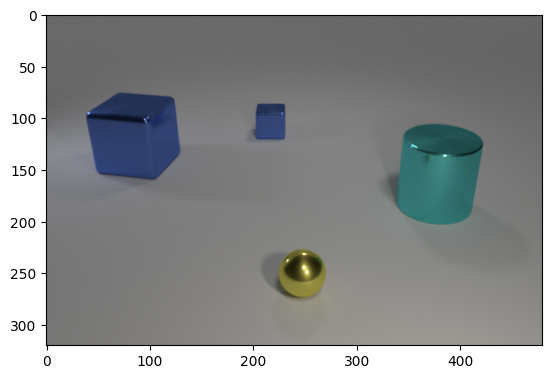

In [4]:
idx = random.randint(0, len(x_train))
img = plt.imread(dataset_base_path + 'images/trainA/' + x_train[idx])
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)
plt.imshow(img)
plt.show()

In [5]:
y_train = json.load(open(dataset_base_path + "scenes/CLEVR_trainA_scenes.json", "r"))
y_val = json.load(open(dataset_base_path + "scenes/CLEVR_valA_scenes.json", "r"))
y_train = y_train['scenes']
y_val = y_val['scenes']
print('Number of training scenes: ', len(y_train))
print('Number of validation scenes: ', len(y_val))
print(f'Sample training data: {y_train[0]}')

Number of training scenes:  70000
Number of validation scenes:  15000
Sample training data: {'image_filename': 'CLEVR_trainA_000000.png', 'objects': [{'pixel_coords': [131, 173, 9.2485990524292], 'size': 'large', 'color': 'yellow', 'material': 'metal', 'shape': 'sphere', '3d_coords': [0.044448722153902054, -2.6995933055877686, 0.699999988079071], 'rotation': 303.2391460924107}, {'pixel_coords': [252, 114, 11.72614574432373], 'size': 'large', 'color': 'cyan', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [-0.4431268870830536, 0.7946366667747498, 0.699999988079071], 'rotation': 155.1092991164171}, {'pixel_coords': [196, 115, 12.643919944763184], 'size': 'small', 'color': 'gray', 'material': 'rubber', 'shape': 'sphere', '3d_coords': [-1.9712634086608887, 0.4360339641571045, 0.3499999940395355], 'rotation': 300.13863658809737}], 'split': 'trainA', 'image_index': 0, 'relationships': {'behind': [[1, 2], [2], []], 'front': [[], [0], [0, 1]], 'left': [[], [0, 2], [0]], 'right': [[1, 2

In [6]:
# Filter y_train and y_val to x_train and x_val (relative paths)
y_train = [y for y in y_train if y['image_filename'] in x_train]
y_val = [y for y in y_val if y['image_filename'] in x_val]
print('Number of training scenes: ', len(y_train))
print('Number of validation scenes: ', len(y_val))
print(f'Sample training data: {y_train[0]}')

Number of training scenes:  700
Number of validation scenes:  150
Sample training data: {'image_filename': 'CLEVR_trainA_000030.png', 'objects': [{'pixel_coords': [277, 116, 11.548401832580566], 'size': 'large', 'color': 'red', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [-0.07860971987247467, 1.0946065187454224, 0.699999988079071], 'rotation': 91.91998761696603}, {'pixel_coords': [307, 176, 9.962418556213379], 'size': 'small', 'color': 'yellow', 'material': 'rubber', 'shape': 'cube', '3d_coords': [1.7698845863342285, 0.20507781207561493, 0.3499999940395355], 'rotation': 19.425017406174142}, {'pixel_coords': [223, 188, 8.914209365844727], 'size': 'large', 'color': 'green', 'material': 'metal', 'shape': 'cylinder', '3d_coords': [1.5800716876983643, -1.6387121677398682, 0.699999988079071], 'rotation': 26.05840353664247}, {'pixel_coords': [340, 117, 12.350903511047363], 'size': 'small', 'color': 'yellow', 'material': 'rubber', 'shape': 'sphere', '3d_coords': [0.3243083953857422

In [7]:
print(y_train[0].keys())
print("----" * 4)
print("Image filename: ", y_train[0]['image_filename'])
print("Split: ", y_train[0]['split'])
print("Image index: ", y_train[0]['image_index'])
print("----" * 4)
print("Objects: ")
for k, v in y_train[0]['objects'][0].items():
    print("\t", k, v)
print("----" * 4)
print("Relationships: ")
for k, v in y_train[0]['relationships'].items():
    print("\t", k, v)
print("----" * 4)
print("Directions: ")
for k, v in y_train[0]['directions'].items():
    print("\t", k, v)

dict_keys(['image_filename', 'objects', 'split', 'image_index', 'relationships', 'directions'])
----------------
Image filename:  CLEVR_trainA_000030.png
Split:  trainA
Image index:  30
----------------
Objects: 
	 pixel_coords [277, 116, 11.548401832580566]
	 size large
	 color red
	 material metal
	 shape cylinder
	 3d_coords [-0.07860971987247467, 1.0946065187454224, 0.699999988079071]
	 rotation 91.91998761696603
----------------
Relationships: 
	 right [[1, 3, 6], [3, 6], [0, 1, 3, 6], [6], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 6], []]
	 front [[1, 2, 5, 6], [2], [], [0, 1, 2, 5, 6], [0, 1, 2, 3, 5, 6], [1, 2, 6], [1, 2]]
	 left [[2, 4, 5], [0, 2, 4, 5], [4, 5], [0, 1, 2, 4, 5], [], [4], [0, 1, 2, 3, 4, 5]]
	 behind [[3, 4], [0, 3, 4, 5, 6], [0, 1, 3, 4, 5, 6], [4], [], [0, 3, 4], [0, 3, 4, 5]]
----------------
Directions: 
	 above [0.0, 0.0, 1.0]
	 right [0.6563112735748291, 0.7544902563095093, -0.0]
	 front [0.754490315914154, -0.6563112735748291, -0.0]
	 behind [-0.754490315914154, 

In [8]:
for k, v in y_train[0]['objects'][0].items():
    print("\t", k, v)

	 pixel_coords [277, 116, 11.548401832580566]
	 size large
	 color red
	 material metal
	 shape cylinder
	 3d_coords [-0.07860971987247467, 1.0946065187454224, 0.699999988079071]
	 rotation 91.91998761696603


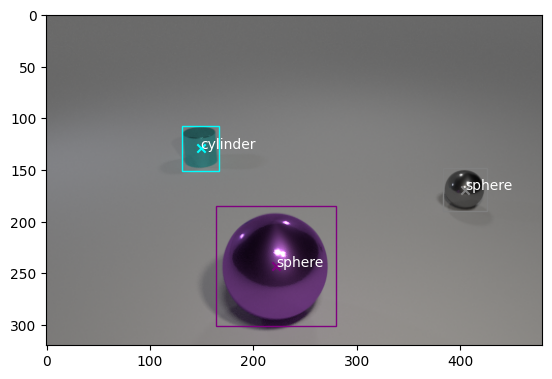

In [9]:
sample = random.randint(0, len(y_train))
img = plt.imread(dataset_base_path + 'images/trainA/' + y_train[sample]['image_filename'])
sizes = {
    "large": 0.7,
    "small": 0.35
}

for _obj in y_train[sample]['objects']:
    plt.scatter(_obj['pixel_coords'][0], _obj['pixel_coords'][1], marker='x', color=_obj['color'])
    plt.text(_obj['pixel_coords'][0], _obj['pixel_coords'][1], _obj['shape'], color='white')
    # plt.text(_obj['pixel_coords'][0], _obj['pixel_coords'][1], int(_obj['rotation']), color='white')
    # plt.gcf().gca().add_artist(plt.Rectangle((_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750, _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750), (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, color=_obj['color'], fill=False))
    if _obj['shape'] == 'sphere':
        plt.gcf().gca().add_artist(
            plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            color=_obj['color'], fill=False)
        )
    elif _obj['shape'] == 'cylinder':
        plt.gcf().gca().add_artist(plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 600 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 750 * 2, 
            color=_obj['color'], fill=False)
        )
    else:
        plt.gcf().gca().add_artist(plt.Rectangle(
            (_obj['pixel_coords'][0] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800, 
            _obj['pixel_coords'][1] - (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800), 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800 * 2, 
            (sizes[_obj['size']] / _obj['pixel_coords'][2]) * 800 * 2, 
            color=_obj['color'], fill=False)
        )

plt.imshow(img)

In [ ]:
# get bounding box
def get_bbox(obj):
    sizes = {
        "large": 0.7,
        "small": 0.35
    }
    bbox = []
    if obj['shape'] == 'sphere':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2]
    elif obj['shape'] == 'cylinder':
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 600, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 750, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 600 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 750 * 2]
    else:
        bbox = [
                obj['pixel_coords'][0] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                obj['pixel_coords'][1] - (sizes[obj['size']] / obj['pixel_coords'][2]) * 800, 
                (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2
                , (sizes[obj['size']] / obj['pixel_coords'][2]) * 800 * 2]
    return bbox

In [ ]:
# Extract data from a scene
def scene_extractor(scene):
    """
    Extracts the following information from a scene:
        - image_filename
        - objects
        - split
        - image_index
        - relationships
        - directions
    """
    # add bounding boxes to objects
    for obj in scene['objects']:
        obj['bbox'] = get_bbox(obj)
    return {
        'image_filename': scene['image_filename'],
        'objects': scene['objects'],
        'split': scene['split'],
        'image_index': scene['image_index'],
        'relationships': scene['relationships'],
        'directions': scene['directions']
    }

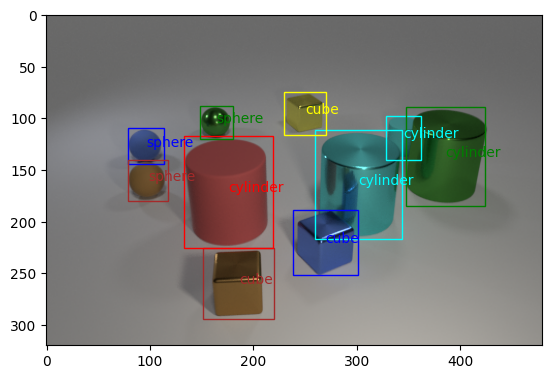

In [12]:
sample = random.randint(0, len(y_train))
scene = scene_extractor(y_train[sample])
# plot sample
img = plt.imread(dataset_base_path + 'images/trainA/' + scene['image_filename'])
# plot bounding boxes
for obj in scene['objects']:
    plt.gcf().gca().add_artist(plt.Rectangle(
        (obj['bbox'][0], obj['bbox'][1]), 
        obj['bbox'][2], 
        obj['bbox'][3], 
        color=obj['color'], fill=False)
    )
    # show labels
    plt.text(obj['pixel_coords'][0], obj['pixel_coords'][1], obj['shape'], color=obj['color'])
    
plt.imshow(img)

In [13]:
class CLEVRDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
        # sort x by filename (CLEVR_trainA_029042.png -> 29042)
        self.x.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        # sort y to match x
        self.y.sort(key=lambda y: y['image_index'])

        self.classes = ['cube', 'sphere', 'cylinder']

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = cv2.imread(dataset_base_path + 'images/trainA/' + self.x[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (self.w, self.h))
        img = img.astype(np.float32)
        img = img / 255.0
        if self.transform:
            img = self.transform(image=img)['image']
        
        scene = scene_extractor(self.y[idx])
        boxes = []
        labels = []
        for obj in scene['objects']:
            boxes.append(obj['bbox'])
            labels.append(self.classes.index(obj['shape']))

        return img, torch.tensor(boxes), torch.tensor(labels)

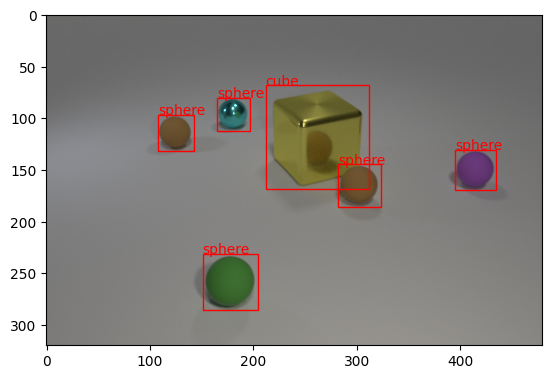

In [14]:
test = CLEVRDataset(x_train, y_train)
# plot sample
img, boxes, labels = test[3]
boxes = boxes.numpy()
labels = labels.numpy()
for i in range(len(boxes)):
    plt.gcf().gca().add_artist(plt.Rectangle(
        (boxes[i][0], boxes[i][1]), 
        boxes[i][2], 
        boxes[i][3], 
        color='r', fill=False)
    )
    # show labels
    plt.text(boxes[i][0], boxes[i][1], test.classes[labels[i]], color='r')
plt.imshow(img)

In [87]:
# ~/.cache/torch/hub/checkpoints/resnet101-*.pth
backbone = resnet_fpn_backbone(
    backbone_name="resnet101", 
    weights="ResNet101_Weights.DEFAULT",
    trainable_layers=3,    
)

In [3]:
# +1 for background
num_classes = num_labels + 1

faster_rcnn = FasterRCNN(backbone=backbone, num_classes=num_classes)

SyntaxError: invalid syntax (1100799675.py, line 1)